# Pepe Image Classification Using Machine Learning

The objective of this notebook is to train a machine learning model and a deep learning model to perform the task of identifying the images of pepe frog.

## Data

The data used to train the models in this notebook is present in hugging face. 
Link :- https://huggingface.co/datasets/vikhyatk/synthetic-pepe

**Note :-** Since the given data only has images of pepe frog, for training and scoring purposes an image classification dataset of pokemon images has been added to the given data.

Pokemon Dataset Link :- https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types

## 1. Importing Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf;

%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier

2024-03-26 01:42:27.780392: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-26 01:42:27.780735: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 01:42:27.785564: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 01:42:27.846576: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 01:42:28.864789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

### Importing The Datasets

In [2]:
pepeFileNames = pd.read_csv("./data/labels.csv")
pokemonFileNames = pd.read_csv("./data/pokemonLabels.csv")

pepeFileNames.size, pokemonFileNames.size

(504, 809)

In [3]:
filepaths = ["./data/pepe-images/" + label for label in pepeFileNames["File Name"]]
filepaths += ["./data/pokemon-images/" + label for label in pokemonFileNames["File Name"]]
filepaths[:10]

['./data/pepe-images/0e4a1d55-261e-4bed-b0db-7c4a66811011.jpeg',
 './data/pepe-images/d9b28405-90ca-4c5e-bc5a-e1df6c2f1b38.jpeg',
 './data/pepe-images/ea0335cb-5bee-4b9d-b9e2-b25afb0c7777.jpeg',
 './data/pepe-images/5cb1251a-080b-4806-a966-4df424c178d0.jpeg',
 './data/pepe-images/22da751a-08da-4aea-b936-7badce43e5dc.jpeg',
 './data/pepe-images/bd9a7404-ef6f-4aa5-aede-e43bb268bbaa.jpeg',
 './data/pepe-images/06d07053-f659-4133-a751-b68272758320.jpeg',
 './data/pepe-images/18c72163-8e0d-461e-95e8-fae1918249ad.jpeg',
 './data/pepe-images/F8jo1Qba8AAYMYt.jpeg',
 './data/pepe-images/d6e9fb51-869e-4cf9-a379-587b11f1c2b6.jpeg']

In [4]:
# verifying the total number of images
len(filepaths), 504 + 500

(1313, 1004)

## 2. Image Preprocessing and Getting The Data Ready For Training

This step includes the following processes:-
* assigning a target classification variable to each image path to identify if the given image is a pepe frog or not.
* preprocessing the image (converting the jpeg files into numpy arrays which can be used to train the data)
* splitting the available data into training validation and test data.

Using the methods of `tensorflow` and `tensorflow.image`, let's define a function which takes the file path as an input argument and processes the image by resizing it and returns a tensor.

### Creating a Target Column

In [5]:
df = pd.DataFrame(filepaths, columns=["File Path"])
df = df.assign(target = [1 if "pepe-images" in path else 0 for path in df["File Path"]]) 
# this statement assigns 1 to the target column of all filepaths which contain the pepe-images folder

In [6]:
df.target.value_counts()

target
0    809
1    504
Name: count, dtype: int64

In [7]:
print(df)

                                              File Path  target
0     ./data/pepe-images/0e4a1d55-261e-4bed-b0db-7c4...       1
1     ./data/pepe-images/d9b28405-90ca-4c5e-bc5a-e1d...       1
2     ./data/pepe-images/ea0335cb-5bee-4b9d-b9e2-b25...       1
3     ./data/pepe-images/5cb1251a-080b-4806-a966-4df...       1
4     ./data/pepe-images/22da751a-08da-4aea-b936-7ba...       1
...                                                 ...     ...
1308                ./data/pokemon-images/spritzee.jpeg       0
1309                 ./data/pokemon-images/roselia.jpeg       0
1310               ./data/pokemon-images/serperior.jpeg       0
1311                ./data/pokemon-images/venusaur.jpeg       0
1312                 ./data/pokemon-images/florges.jpeg       0

[1313 rows x 2 columns]


In [8]:
# saving the dataset as a csv file for future use.
df.to_csv("./data/dataset.csv", index=False)

### Image Preprocessing Function

In [9]:
IMG_SIZE = 200

def processImage(imagePath):
    """
    Converts the image in imagePath into its respective numpy array.
    """

    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3) # converts into tensor with three channels (RGB)
    image = tf.image.convert_image_dtype(image, tf.float32) # normalizing to 0-1 values
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    image = image.numpy() # converts the tensor into a 3d numpy array
    return np.reshape(image, -1) # converts the 3d array into a 1d array in order to directly pass the 1d array into the model.

In [10]:
#testing the preprocessing function
processImage(df["File Path"][0])

2024-03-26 01:42:29.743643: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-03-26 01:42:29.743675: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: hvootukuri-Inspiron-5509
2024-03-26 01:42:29.743682: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: hvootukuri-Inspiron-5509
2024-03-26 01:42:29.743851: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 535.161.7
2024-03-26 01:42:29.743871: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 535.161.7
2024-03-26 01:42:29.743876: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 535.161.7


array([0.28387925, 0.21029648, 0.14387922, ..., 0.4987451 , 0.39031056,
       0.23691289], dtype=float32)

### Splitting The Data into Train and Test Splits

In [11]:
X_filePaths = df.drop("target", axis=1)

In [12]:
for i in range(len(X_filePaths)):
    X_filePaths.loc[i, "File Path"] = processImage(X_filePaths.loc[i, "File Path"])

X_fileData = X_filePaths.rename(columns={"File Path" : "File Data"})

In [13]:
X_fileData

,File Data
0,"[0.28387925, 0.21029648, 0.14387922, 0.2500031..."
1,"[0.3961271, 0.42676553, 0.43847376, 0.05503212..."
2,"[0.18804237, 0.02283765, 0.030431377, 0.221189..."
3,"[0.7585036, 0.47453964, 0.68835765, 0.80371463..."
4,"[0.0438149, 0.13837491, 0.31070274, 0.04665412..."
...,...
1308,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1309,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1310,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1311,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Since each row of the dataframe representing the data of an image is in the form of an array,
le us convert each array into a row in a new dataframe in order to use that data for training and testing the model.

In [14]:
X = pd.DataFrame(X_fileData.loc[0, "File Data"]).T

for i in range(1,len(X_filePaths)):
    X = pd.concat([X, pd.DataFrame(X_fileData.loc[i, "File Data"]).T])

X

,0,1,2,3,4,5,6,7,8,9,...,119990,119991,119992,119993,119994,119995,119996,119997,119998,119999
0,0.283879,0.210296,0.143879,0.250003,0.172670,0.111343,0.329945,0.229075,0.161161,0.233566,...,0.413863,0.177632,0.095671,0.000000,0.491294,0.397490,0.240627,0.498745,0.390311,0.236913
0,0.396127,0.426766,0.438474,0.055032,0.039812,0.031167,0.644714,0.551992,0.558612,0.651518,...,0.341706,0.318207,0.131331,0.148344,0.411817,0.114332,0.077584,0.022560,0.007594,0.003465
0,0.188042,0.022838,0.030431,0.221189,0.026510,0.033931,0.249671,0.048165,0.034376,0.378814,...,0.540395,0.331421,0.221161,0.499963,0.142610,0.081778,0.240299,0.428177,0.417104,0.726452
0,0.758504,0.474540,0.688358,0.803715,0.554240,0.753017,0.949953,0.718667,0.874965,0.820977,...,0.489831,0.154731,0.068604,0.020450,0.946280,0.758276,0.876393,0.993341,0.907792,0.987102
0,0.043815,0.138375,0.310703,0.046654,0.117435,0.265514,0.088227,0.123522,0.250580,0.174469,...,0.109294,0.084416,0.089505,0.086455,0.135823,0.058459,0.090973,0.237459,0.117260,0.105745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


now the data is ready to be used for training the machine learning model.

In [15]:
y = df["target"]
y

0       1
1       1
2       1
3       1
4       1
       ..
1308    0
1309    0
1310    0
1311    0
1312    0
Name: target, Length: 1313, dtype: int64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

## 3. Training The Model

Let us use a dictionary to store the model which we are going to train as it is easier to add more models and call a user defined function `fitAndScore()` to train all the models present in  the dictionary and returns the accuracy scores of the models.

This notebook uses the `KNeighborsClassifier` estimator in order to build the required model.

In [17]:
models = {
    "KNN" : KNeighborsClassifier(),
}

def fitAndScore(models, X_train, X_test, y_train, y_test):
    """
    Fits and evalueates given machine learning models.
    models : a dict of different scikit-learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels associated with training data
    y_test : labels associated with test data
    """
    modelScores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        modelScores[name] = model.score(X_test, y_test)
    return modelScores

In [18]:
modelScores = fitAndScore(models=models,
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test)

modelScores

{'KNN': 0.9809885931558935}

## 4. Hyperparameter Tuning


Now that the model has been trained, let us try to improve our model by tuning the hyperparameters.

This notebook will be using the `RandomizedSearchCV` function in order to find the best suitable hyperparameters which can be used for this specific dataset.

In [19]:
knn = KNeighborsClassifier()

knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [20]:
knnGrid = {"algorithm": ["ball_tree", "auto", "kd_tree"],
           "n_neighbors": [5,7,10,12],
           "p": [1,2],
           "metric": ["minkowski"]}

In [21]:
# rsKnn = RandomizedSearchCV(KNeighborsClassifier(),
#                                 param_distributions=knnGrid,
#                                 cv=5,
#                                 n_iter=20,
#                                 verbose=True)

# rsKnn.fit(X_train, y_train)

# rsKnn.best_params_

In [22]:
# rsKnn.score(X_test, y_test)

## 5. Evaluation

now let us evaluate the performance of our model using scoring metrics such as `f1_score`, `precision_score`, `recall_score` and the Confusion Matrix

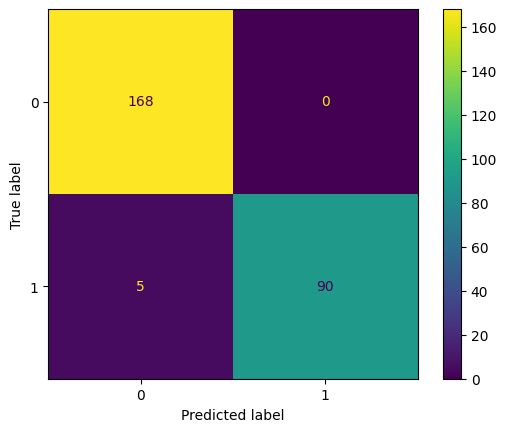

In [23]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

cm = confusion_matrix(y_test, predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm)

display.plot()

The Confusion Matrix Shows you the number of true negatives, false positives, false negatives and true positives respectively. The confusion matrix allows us to analyse which predictions the trained model is struggling with.

Now, let us use the `classification_report` to look at all scoring metrics.

In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       168
           1       1.00      0.95      0.97        95

    accuracy                           0.98       263
   macro avg       0.99      0.97      0.98       263
weighted avg       0.98      0.98      0.98       263

